In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import warnings
import pickle
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.preprocessing import OneHotEncoder 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier 
from category_encoders import OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from lazypredict.Supervised import LazyClassifier
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('comptab_2018-01-29 16_00_comma_separated.csv')

In [3]:
df.head()

,Year,App.,Taxon,Class,Order,Family,Genus,Importer,Exporter,Origin,Importer reported quantity,Exporter reported quantity,Term,Unit,Purpose,Source
0,2016,I,Aquila heliaca,Aves,Falconiformes,Accipitridae,Aquila,TR,NL,CZ,NaN,1.00,bodies,NaN,T,C
1,2016,I,Aquila heliaca,Aves,Falconiformes,Accipitridae,Aquila,XV,RS,RS,NaN,1.00,bodies,NaN,Q,O
2,2016,I,Haliaeetus albicilla,Aves,Falconiformes,Accipitridae,Haliaeetus,BE,NO,NaN,NaN,43.00,feathers,NaN,S,W
3,2016,I,Haliaeetus albicilla,Aves,Falconiformes,Accipitridae,Haliaeetus,BE,NO,NaN,NaN,43.00,specimens,NaN,S,W
4,2016,I,Haliaeetus albicilla,Aves,Falconiformes,Accipitridae,Haliaeetus,DK,IS,NaN,700.00,NaN,specimens,NaN,S,W


In [4]:
df["App."].unique()

array(['I', 'II', 'III', 'N'], dtype=object)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67161 entries, 0 to 67160
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Year                        67161 non-null  int64  
 1   App.                        67161 non-null  object 
 2   Taxon                       67161 non-null  object 
 3   Class                       46937 non-null  object 
 4   Order                       67104 non-null  object 
 5   Family                      66700 non-null  object 
 6   Genus                       65702 non-null  object 
 7   Importer                    67090 non-null  object 
 8   Exporter                    66588 non-null  object 
 9   Origin                      25643 non-null  object 
 10  Importer reported quantity  31866 non-null  float64
 11  Exporter reported quantity  44021 non-null  float64
 12  Term                        67161 non-null  object 
 13  Unit                        640

In [6]:
df.describe()

,Year,Importer reported quantity,Exporter reported quantity
count,67161.00,31866.00,44021.00
mean,2016.00,4382.43,4443.88
std,0.05,144910.27,157379.36
min,2016.00,0.00,0.00
25%,2016.00,3.00,2.00
50%,2016.00,12.00,12.00
75%,2016.00,80.00,82.00
max,2017.00,19524978.00,21543618.00


In [8]:
def wrangle(df, threshold=30000):

    # Drop columns with more than set threshold of non-null values
    model_df = df.dropna(axis=1, thresh=threshold)
    
    # Fill null values in import and export quantities to depict negation
    float_columns = list(model_df.select_dtypes('float').columns)
    
    model_df[float_columns] = model_df[float_columns].fillna(0)

    # Drop nulls nulls `from model_df`
    model_df.dropna(inplace=True)
    
    # Convert `Year` to string
    model_df["Year"] = model_df["Year"].astype(str)
    
    min_thresold_import, max_thresold_import = df['Importer reported quantity'].quantile([0.05,0.99])
    min_thresold_export, max_thresold_export = df['Exporter reported quantity'].quantile([0.05,0.99])

    model_df = df[((df['Importer reported quantity']<max_thresold_import) & (df['Importer reported quantity']>min_thresold_import))
        & ((df['Exporter reported quantity']<max_thresold_export) & (df['Exporter reported quantity']>min_thresold_export))
       ]
    
    drop_cols = ['Origin','Unit']
    model_df.drop(drop_cols, axis=1, inplace=True)
    
    # Drop nulls nulls `from model_df`
    model_df.dropna(inplace=True)
    
   
    return model_df

In [9]:
model_df = wrangle(df)

In [10]:
model_df.head()

,Year,App.,Taxon,Class,Order,Family,Genus,Importer,Exporter,Importer reported quantity,Exporter reported quantity,Term,Purpose,Source
45,2016,I,Oreonax flavicauda,Mammalia,Primates,Atelidae,Oreonax,DE,PE,70.00,50.00,specimens,S,W
57,2016,I,Balaena mysticetus,Mammalia,Cetacea,Balaenidae,Balaena,NO,GL,500.00,500.00,specimens,S,W
128,2016,I,Megaptera novaeangliae,Mammalia,Cetacea,Balaenopteridae,Megaptera,DK,GL,2.00,3.00,baleen,P,W
130,2016,I,Megaptera novaeangliae,Mammalia,Cetacea,Balaenopteridae,Megaptera,DK,GL,18.00,83.00,specimens,S,W
144,2016,I,Megaptera novaeangliae,Mammalia,Cetacea,Balaenopteridae,Megaptera,US,OM,49.00,49.00,specimens,S,W


In [11]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6056 entries, 45 to 66806
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Year                        6056 non-null   int64  
 1   App.                        6056 non-null   object 
 2   Taxon                       6056 non-null   object 
 3   Class                       6056 non-null   object 
 4   Order                       6056 non-null   object 
 5   Family                      6056 non-null   object 
 6   Genus                       6056 non-null   object 
 7   Importer                    6056 non-null   object 
 8   Exporter                    6056 non-null   object 
 9   Importer reported quantity  6056 non-null   float64
 10  Exporter reported quantity  6056 non-null   float64
 11  Term                        6056 non-null   object 
 12  Purpose                     6056 non-null   object 
 13  Source                      6056 non

In [12]:
model_df.describe()

,Year,Importer reported quantity,Exporter reported quantity
count,6056.00,6056.00,6056.00
mean,2016.00,509.79,629.52
std,0.00,2009.85,2227.83
min,2016.00,1.07,1.14
25%,2016.00,8.00,9.00
50%,2016.00,32.00,42.00
75%,2016.00,174.00,243.00
max,2016.00,34262.00,28378.00


In [13]:
def split_data():
    X = model_df.drop("App.",axis=1)
    y = model_df["App."] 
    return train_test_split(X, y,test_size=0.3,random_state =42) 

In [14]:
def resample():
    X_train = split_data()[0]
    y_train = split_data()[2]
    X_train_over, y_train_over = RandomOverSampler(random_state=42).fit_resample(X_train,y_train)
    return X_train_over, y_train_over

In [15]:
def build_model(voting="hard"):
    estimator = [] 
    estimator.append(('LR',  
                      LogisticRegression(solver ='lbfgs',  
                                         multi_class ='multinomial',  
                                         max_iter = 200))) 
    estimator.append(('SVC', SVC(gamma ='auto', probability = True))) 
    estimator.append(('DTC', DecisionTreeClassifier(max_depth=10))) 
    estimator.append(('RFC', RandomForestClassifier(random_state=42))) 
    estimator.append(('GBC', GradientBoostingClassifier()))

    # Voting Classifier with hard voting 
    # Build Model
    model = make_pipeline(
        OrdinalEncoder(), 
        VotingClassifier(estimators = estimator, voting = voting) 
    )
    X_train_over, y_train_over = resample()
    model.fit(X_train_over, y_train_over)
    return model

In [16]:
model = build_model()

In [18]:
 X_train, X_test, y_train, y_test = split_data()

In [19]:
y_pred = model.predict(X_test)
print("Test Accuracy:", round(accuracy_score(y_test, y_pred), 2))

Test Accuracy: 0.97


In [20]:
print("Train Accuracy:", round(model.score(X_train, y_train), 2))

Train Accuracy: 0.99


In [21]:
print(classification_report(y_test,model.predict(X_test)))

              precision    recall  f1-score   support

           I       0.91      0.89      0.90       130
          II       0.99      0.99      0.99      1663
         III       0.56      0.62      0.59        24

    accuracy                           0.97      1817
   macro avg       0.82      0.83      0.82      1817
weighted avg       0.97      0.97      0.97      1817



In [62]:
model.feature_names_in_

['Year',
 'Taxon',
 'Class',
 'Order',
 'Family',
 'Genus',
 'Importer',
 'Exporter',
 'Importer reported quantity',
 'Exporter reported quantity',
 'Term',
 'Purpose',
 'Source']

In [63]:
X_train_over.columns

Index(['Year', 'Taxon', 'Class', 'Order', 'Family', 'Genus', 'Importer',
       'Exporter', 'Importer reported quantity', 'Exporter reported quantity',
       'Term', 'Purpose', 'Source'],
      dtype='object')

In [82]:
# Checking to see if the features are same as the training data columns
all(model.feature_names_in_) == all(X_train_over.columns)

True

In [70]:
model.named_steps["votingclassifier"].estimators_

[LogisticRegression(max_iter=200, multi_class='multinomial'),
 SVC(gamma='auto', probability=True),
 DecisionTreeClassifier(max_depth=10),
 RandomForestClassifier(random_state=42),
 GradientBoostingClassifier()]

In [71]:
for model in model.named_steps["votingclassifier"].estimators_:
    if hasattr(model, 'feature_importances_'):
        feature_importances_model = model.feature_importances_

In [106]:
# Get feature names from training data
features = model.feature_names_in_

# Create a series with feature names and importances
feat_imp = pd.Series(feature_importances_model,index=features).sort_values(ascending=False)

In [107]:
feat_imp

Family                       0.34
Source                       0.18
Purpose                      0.14
Term                         0.11
Order                        0.07
Exporter                     0.04
Class                        0.04
Taxon                        0.03
Genus                        0.03
Exporter reported quantity   0.02
Importer                     0.01
Importer reported quantity   0.00
Year                         0.00
dtype: float64

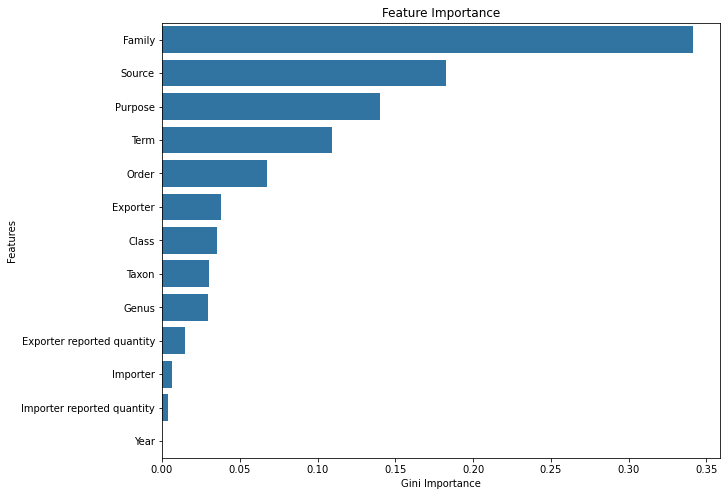

In [105]:
import seaborn as sns
# Create a horizontal bar plot
plt.figure(figsize=(10,8))
sns.barplot(x=feat_imp.values, y=feat_imp.index, orient='h',color=sns.color_palette()[0])
plt.xlabel("Gini Importance")
plt.ylabel("Features")
plt.title("Feature Importance");

In [104]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

### Checking model deserialization

In [45]:
model_path = 'model_2023-10-28T14:36:54.764493.pkl'

# Load the model from the file
with open(model_path, 'rb') as file:
    loaded_model = pickle.load(file)

In [46]:
loaded_model

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Taxon', 'Class', 'Order', 'Family',
                                      'Genus', 'Importer', 'Exporter', 'Term',
                                      'Purpose', 'Source'],
                                mapping=[{'col': 'Taxon',
                                          'data_type': dtype('O'),
                                          'mapping': Crocodylus novaeguineae        1
Pecari tajacu                  2
Platycercus elegans            3
Python reticulatus             4
Tupinambis teguixin            5
                            ... 
Melanosuchus niger           680
Tupaia montana               681
Callithrix pygmaea...
                                          'data_type': dtype('O'),
                                          'mapping': W      1
C      2
F      3
R      4
D      5
O      6
I      7
U      8
NaN   -2
dtype: int64}])),
                ('votingclassifier',
                 VotingClassifier(estimators=[('LR',
                                               LogisticRegression(max_iter=200,
                                                                  multi_class='multinomial')),
                                              ('SVC',
                                               SVC(gamma='auto',
                                                   probability=True)),
                                              ('DTC',
                                               DecisionTreeClassifier(max_depth=10)),
                                              ('RFC',
                                               RandomForestClassifier(random_state=42)),
                                              ('GBC',
                                               GradientBoostingClassifier())]))])

In [47]:
loaded_model.score(X_test, y_test)

0.9757842597688497